### Import packages and establish notebook settings

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import regex as re
import pickle
import emoji
import unidecode

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.html.use_mathjax', False) # normalize fonts for pandas display
pd.options.display.max_colwidth = None

# custom functions
from utils import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### My Fathers Jokes

In [2]:
# Take a look at my fathers jokes
for joke in DADS_JOKES:
    print('--------')
    print(f'{joke[0]}\n{joke[1]}')

--------
Police car loses wheels to thief!
Cops are working tirelessly to nab suspect
--------
My friend David had his id stolen
now he is just Dav.
--------
I have a few jokes about unemployed people
but none of them ever work
--------
I know a gut that talked and talked and talked...
...It was clear that there needed to be an organization similar to Q-Anon for compulive talkers called Onandon-andon
--------
My ex-wife still misses me.
But her aim is starting to improve.
--------
An invisible man married an invisible woman.
Their kids were nothing to look at.
--------
Did you know that a raven has 17 rigid feathers called pinions, while a crow only has 16?
Apparently, the only difference between a raven and a crow is a matter of a pinion.
--------
A painter was the only painter in town...
...And he tended to take advantage of this by diluting his paint a bit with turpentine. One day he was asked to paint the church steeple. He was about half done, standing high on a ladder, when a clo

### Read-in and explore the dataset
The dataset is downloaded and read into a pandas data frame. A quick examination of the data shows that the dataset contains one million instances with 12 features, most of which aren't relevent to

In [3]:
# extract the data
df = pd.read_csv('https://query.data.world/s/htrdsouy327xqa4w457qx6k6sjtj6r')

In [4]:
# examine the data
df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,ftbp1i,2qh72,jokes,False,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i/i_am_soooo_glad_im_not_circumcised/,self.jokes,NaN,My corona is covered with foreskin so it is not exposed to viruses.,I am soooo glad I'm not circumcised!,2
1,post,ftboup,2qh72,jokes,False,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup/did_you_know_google_now_has_a_platform_for/,self.jokes,NaN,It's called Google Sheets.,Did you know Google now has a platform for recording your bowel movements?,9
2,post,ftbopj,2qh72,jokes,False,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj/what_is_the_difference_between_my_wife_and_my/,self.jokes,NaN,"The vacuum doesn't snore after sex.\n\n&amp;#x200B;\n\nApril fools, I don't have a wife.",What is the difference between my wife and my vacuum?,15
3,post,ftbnxh,2qh72,jokes,False,1585785428,https://old.reddit.com/r/Jokes/comments/ftbnxh/my_last_joke_for_now/,self.jokes,NaN,[removed],My last joke for now.,9
4,post,ftbjpg,2qh72,jokes,False,1585785009,https://old.reddit.com/r/Jokes/comments/ftbjpg/the_nintendo_64_turns_18_this_week/,self.jokes,NaN,[removed],The Nintendo 64 turns 18 this week...,134


In [5]:
df.shape

(1000000, 12)

In [6]:
df[['title', 'selftext', 'score']].head(10)

,title,selftext,score
0,I am soooo glad I'm not circumcised!,My corona is covered with foreskin so it is not exposed to viruses.,2
1,Did you know Google now has a platform for recording your bowel movements?,It's called Google Sheets.,9
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex.\n\n&amp;#x200B;\n\nApril fools, I don't have a wife.",15
3,My last joke for now.,[removed],9
4,The Nintendo 64 turns 18 this week...,[removed],134
5,Sex with teacher.,[removed],1
6,Another long one.,[removed],8
7,What did the French man say to the attractive teletubby?,Oo..lala...,2
8,A Priest takes a walk down to the docks one day,[removed],88
9,A long joke.,[removed],4


In [7]:
df['score'].describe()

count    1000000.000000
mean         139.691119
std         1674.046005
min            0.000000
25%            0.000000
50%            1.000000
75%            7.000000
max       142733.000000
Name: score, dtype: float64

Saving figure scores distribution


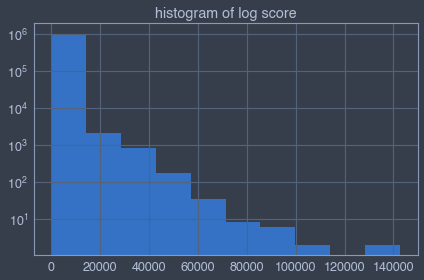

In [8]:
plt.hist(df['score'], log=True)
plt.title('histogram of log score')
save_fig('scores distribution')

In [9]:
# define some parameters 
CLASS_SIZE = 50000
TRAIN_SIZE = 0.95
MIN_UPVOTES = 100
MAX_UPVOTES = df['score'].max()
TITLE_MAX_LEN = 150
SELFTEXT_MAX_LEN = 500

## Data Cleaning

Our raw data is truly unruly, being sourced from the [r/Jokes subreddit](https://www.reddit.com/r/Jokes/), and so will require a fair bit of wrangling to get into a useable form. Part of the challenge is that the relevent information we are looking to isolate (the joke and punchline) are within a sea of noisy data; raw internet data tends to be replete with odd characters, emojis, hmtl character references, links, mispellings, null values, and user edits that mask the useful data, making the data more unruly and harder to work with. I will thus be proceeding carefully by closely examing the data during cleaning and making judicious use of test cases to ensure that I am getting the results I expect.

In [10]:
# boolean masks
# where selftext isnull (no punchline)
is_null = df['selftext'].isnull()

# where title or post were removed by reddit user/mod
removed = (df['selftext'].str.contains(r"(?i)[^a-z\s]removed[^a-z\s]", regex=True)) | (df['title'].str.contains(r"(?i)[^a-z\s]removed[^a-z\s]", regex=True)) 

# where tile or post were deleted by the original poster
deleted = (df['selftext'].str.contains(r"(?i)[^a-z\s]deleted[^a-z\s]", regex=True)) | (df['title'].str.contains(r"(?i)[^a-z\s]deleted[^a-z\s]", regex=True)) 

# reposts
duplicated = df.duplicated(subset=['title', 'selftext'], keep='first')

# where upvotes is 0 (reddit automatically provides user 1 upvote)
neg_class = df['score'] == 0

In [11]:
# get entries that aren't removed or deleted
df_cleaned = df[~removed][~deleted][~duplicated].copy()
df_cleaned.shape

(565332, 12)

In [12]:
print("what are NaNs?")
display(df_cleaned[df_cleaned['score'] > 2000][is_null][['title', 'selftext', 'score']].head(10))
df_cleaned = df_cleaned[~is_null]

what are NaNs?


,title,selftext,score
308797,What happens when you cross a joke with a rhetorical question?,NaN,3938
625315,The funniest /r/jokes has ever been,NaN,67950
914649,Shout out to people who don't know the opposite of in,NaN,4580
915783,5 out of 6 scientists say Russian Roulette is safe.,NaN,10085
919422,"Accordion to a recent survey, replacing words with the names of musical instruments in a sentence often goes undetected.",NaN,12580
927114,"Never make fun of a fat girl with a lisp, she's probably thick and tired of it.",NaN,7848
931755,"6:30 is the best time on a clock, hands down.",NaN,2173
933895,"Bruce Jenner winning woman of the year just proves that men are better than women at everything, including being a woman",NaN,11999
935376,"I often say to myself, ""I can't believe that cloning machine worked.""",NaN,6524
937567,How Long is a Chinese name.,NaN,2404


In [13]:
# removing html character references and escape characters and newline characters
PATTERN = r"[^a-z\s]?(&\S+;)[^a-z\s]?"

# get examples of instances containing pattern
print("samples instances containing pattern :")
html_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
display(df_cleaned.loc[html_idx][['title', 'selftext']].head())

# see changes
print("transformed instances :")
df_cleaned[['title', 'selftext']] = df_cleaned[['title', 'selftext']].applymap(lambda x: re.sub(PATTERN, " ", x.replace("\n", " ")))
display(df_cleaned.loc[html_idx][['title', 'selftext']].head())

samples instances containing pattern :


,title,selftext
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex.\n\n&amp;#x200B;\n\nApril fools, I don't have a wife."
216,Chief Walking Horse has a terrible case of constipation,"So he travels to the local outpost, where he sits down to talk with the Army doctor.\n\n&amp;#x200B;\n\n""Many moons pass, and chief Walking Horse no go number two."" He complains.\n\n&amp;#x200B;\n\nThe doctor reaches into his cabinet and fishes out a mild laxative.\n\n&amp;#x200B;\n\n""Here, Chief, take 1 teaspoon of this every 3 hours, and come back and see me in two days.""\n\n&amp;#x200B;\n\nThe chief took the little bottle, and left back to his village.\n\n&amp;#x200B;\n\nTwo days later, ask the Doctor requested, he's back.\n\n&amp;#x200B;\n\n""Chief Walking Horse, have you moved yet?""\n\n&amp;#x200B;\n\nThe chief slowly shakes his head no.\n\n&amp;#x200B;\n\n""OK, Chief, I'm going to have you double that dosage. I want you to take 2 teaspoons every 3 hours.""\n\n&amp;#x200B;\n\nThe chief nods his head yes, and leaves to return to his village.\n\n&amp;#x200B;\n\nThis repeats itself a couple more times, and the Doctor is growing very concerned. Finally, out of frustration, he grabs another bottle of laxative, and tells the chief to drink the whole thing.\n\n&amp;#x200B;\n\nA few days later, while visiting a close by settlement, the Doctor sees the Chief.\n\n&amp;#x200B;\n\n""Chief Walking Horse! It is good to see you. Tell me, have you moved yet?""\n\n&amp;#x200B;\n\nThe chief looks at him with a grimace and says. ""Chief Moved yesterday. Teepee full of shit!"""
464,How do you waste people's time?,&gt;!not like this !&lt;/ &gt;! not like this not like this !&lt;/&gt;! / not like this!&lt;\n\n&amp;#x200B;\n\n&gt;!not like this tooo!&lt; .&gt;!not like this also !&lt;&gt;!look somewhere else!&lt;\n\n&amp;#x200B;\n\n&gt;!Not like this either !&lt; . &gt;! not like this !&lt;.&gt;! not like this!&lt;
532,I touched my girlfriends ass and she farted.,&amp;#x200B;\n\n&amp;#x200B;\n\nIt was a booty trap.
700,Lost (Limerick and Joke),"There once was a man who was always lost.\n\nHe would buy a map at any cost.\n\nOne day on a trip,\n\nhe heard his map rip,\n\nso into a trashcan, he tossed.\n\n&amp;#x200B;\n\nHe wandered and wandered with no aim.\n\nHe started to think it was a game.\n\nBut with no end in sight\n\nand quickly losing light,\n\nhe started back the way he came.\n\n&amp;#x200B;\n\nHe cried and threw his hands in the air;\n\nhe screamed and shouted with despair.\n\n""Could anyone help?""\n\nThen he started with a yelp.\n\nThere was another man, but trust him, he dare?\n\n&amp;#x200B;\n\n""I gotchu,"" the man said with a grin.\n\n""Come on, I'll help you, hop in.""\n\nHe got in his car,\n\nthey drove pretty far:\n\nfor the traveler, it seemed a big win.\n\n&amp;#x200B;\n\nThe driver took the man to a club:\n\nhe assumed there'd be a phone at a pub.\n\nSo, in the men went,\n\nand a message to his wife, the traveler sent.\n\nThen at a deli next door, they ordered a sub.\n\n&amp;#x200B;\n\nSuddenly thirsty, the traveler got,\n\nso back to the club for drinks, he sought.\n\nHe was bad at navigating,\n\nthe driver was hating,\n\nbut he pressed on, getting lost quite a lot.\n\n&amp;#x200B;\n\nAt last, he found the club just fine,\n\nbut he didn't want a beer or wine.\n\nHe pushed through the crowd,\n\n and yelled out quite loud, \n\n""Hey man, where's the punchline?"""


transformed instances :


,title,selftext
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex. April fools, I don't have a wife."
216,Chief Walking Horse has a terrible case of constipation,"So he travels to the local outpost, where he sits down to talk with the Army doctor. ""Many moons pass, and chief Walking Horse no go number two."" He complains. The doctor reaches into his cabinet and fishes out a mild laxative. ""Here, Chief, take 1 teaspoon of this every 3 hours, and come back and see me in two days."" The chief took the little bottle, and left back to his village. Two days later, ask the Doctor requested, he's back. ""Chief Walking Horse, have you moved yet?"" The chief slowly shakes his head no. ""OK, Chief, I'm going to have you double that dosage. I want you to take 2 teaspoons every 3 hours."" The chief nods his head yes, and leaves to return to his village. This repeats itself a couple more times, and the Doctor is growing very concerned. Finally, out of frustration, he grabs another bottle of laxative, and tells the chief to drink the whole thing. A few days later, while visiting a close by settlement, the Doctor sees the Chief. ""Chief Walking Horse! It is good to see you. Tell me, have you moved yet?"" The chief looks at him with a grimace and says. ""Chief Moved yesterday. Teepee full of shit!"""
464,How do you waste people's time?,not like this not like this not like this / not like this not like this tooo not like this also look somewhere else Not like this either . not like this not like this
532,I touched my girlfriends ass and she farted.,It was a booty trap.
700,Lost (Limerick and Joke),"There once was a man who was always lost. He would buy a map at any cost. One day on a trip, he heard his map rip, so into a trashcan, he tossed. He wandered and wandered with no aim. He started to think it was a game. But with no end in sight and quickly losing light, he started back the way he came. He cried and threw his hands in the air; he screamed and shouted with despair. ""Could anyone help?"" Then he started with a yelp. There was another man, but trust him, he dare? ""I gotchu,"" the man said with a grin. ""Come on, I'll help you, hop in."" He got in his car, they drove pretty far: for the traveler, it seemed a big win. The driver took the man to a club: he assumed there'd be a phone at a pub. So, in the men went, and a message to his wife, the traveler sent. Then at a deli next door, they ordered a sub. Suddenly thirsty, the traveler got, so back to the club for drinks, he sought. He was bad at navigating, the driver was hating, but he pressed on, getting lost quite a lot. At last, he found the club just fine, but he didn't want a beer or wine. He pushed through the crowd, and yelled out quite loud, ""Hey man, where's the punchline?"""


In [14]:
# find edits:
PATTERN = "(?i)[^a-z](edit)\W.+"

# clean posts to change this ... 
print("samples instances containing pattern :")
edits_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
display(df_cleaned.loc[edits_idx][['title', 'selftext']].head())

# remove user edits added after user posted content
df_cleaned[['title', 'selftext']] = df_cleaned[['title', 'selftext']].applymap(lambda x:re.sub(PATTERN, " ", x))

# into this ...
print("transformed instances :")
display(df_cleaned[['title', 'selftext']].loc[edits_idx].head())

samples instances containing pattern :


,title,selftext
803,I used to know an English professor who was pretty smart with books....,But she was dumb when it came to regular shit. She didn't even know that rain was something you need to come in to from out of. EDIT: IOW she didn't like sentences that ended in five prepositions.
825,Two Parrots.,"Two parrots sat on a perch. One parrot looked at the other and said ""Do you smell fish?"" The other parrot replied ""Oh my, a talking bird."" *edit: spelling*"
916,"Italians are always adding -a to words. (It's-a me, Mario!)","I find it to be a horrible corruption of the English language. I say pizz and past, like a _real_ American. Edit: wording"
1096,A man with a COVID-19 walks into the bar,...and is told to leave. [edit]: I'm gonna go offline for 14 days for hating myself.
1124,People that celebrate April fools are...,April ~~dumb people~~ idiot heads. Owned. Edit: punch line


transformed instances :


,title,selftext
803,I used to know an English professor who was pretty smart with books....,But she was dumb when it came to regular shit. She didn't even know that rain was something you need to come in to from out of.
825,Two Parrots.,"Two parrots sat on a perch. One parrot looked at the other and said ""Do you smell fish?"" The other parrot replied ""Oh my, a talking bird."""
916,"Italians are always adding -a to words. (It's-a me, Mario!)","I find it to be a horrible corruption of the English language. I say pizz and past, like a _real_ American."
1096,A man with a COVID-19 walks into the bar,...and is told to leave.
1124,People that celebrate April fools are...,April ~~dumb people~~ idiot heads. Owned.


In [15]:
# user added brackets
PATTERN = r"(\(.*?\))|(\[.*?\])|(\{.*?\})"

print("samples instances containing pattern :")
brackets_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
display(df_cleaned.loc[brackets_idx][['title', 'selftext']].head())

print("transformed instances :")
df_cleaned[['title', 'selftext']] = df_cleaned[['title', 'selftext']].applymap(lambda x: re.sub(PATTERN, "", x))
display(df_cleaned.loc[brackets_idx][['title', 'selftext']].head())

samples instances containing pattern :


,title,selftext
289,Before VS After Marriage,Before Marriage: Boy: Ah at last. I can hardly wait. Girl: Do you want me to leave? Boy: No don't even think about it. Girl: Do you love me? Boy: Of Course. Always have and always will. Girl: Have you ever cheated on me? Boy: Never. Why are you even asking? Girl: Will you kiss me? Boy: Every chance I get. Girl: Will you hit me? Boy: Hell no. Are you crazy? Girl: Can I trust you? Boy: Yes. Girl: Darling! After Marriage: (Read from bottom to top)
410,Three American colonels are in the US about to retire and they are offered an economic compensation...,"..which consists of multiplying 100,000 dollars by the distance in inches they have between two parts of their body that they choose. Colonel McDowell chooses this distance to be from his toe to the edge of his longest hair on his head and the result is 72 inches, so that means he gets $7,200,000. Colonel Smith chooses the reach of his arms, that is from the tip of his right index finger to the tip of his left index finger, which results in a distance of 75 inches (so he gets $7.5M). Finally Colonel McConaughey chooses the distance from the tip of his penis to his balls -""*Colonel, choose two parts that are more separated, you'll win more money that way!*"" - says the soldier in charge of the measurement. -""*No, i'm sure these are the parts i want measured, please proceed!*"" - answers the colonel. The soldier then proceeds to take the measuring tape from the tip of colonel's dick and stretches the tape to reach the balls when suddenly he stops and asks ""*Wait...where are your balls*?!"" -""*I lost them in Vietnam*"""
428,"Doctor: ""i'm sorry to say you've got lung cancer.""","Patient: [tearing up] ""oh god, no!"" Doctor: ""Sorry to say it because it's not true, lol April Fools!"" Patient: [angry] ""What the hell?"" Doctor: ""Yeah, pranked you, the cancer's in your pancreas."""
553,A man's wife goes missing...,"Husband: My wife is missing. She went out yesterday and has not come home... Sergeant at Police Station: What is her height? Husband: Gee, I'm not sure. A little over five-feet tall. Sergeant: Weight? Husband: Don't know. Not slim, not really fat. Sergeant: Colour of eyes? Husband: Sort of brown I think. Never really noticed. Sergeant: Colour of hair? Husband: Changes a couple times a year. Maybe dark brown now. I can’t remember. Sergeant: What was she wearing? Husband: Could have been pants, or maybe a skirt or shorts. I don't know exactly. Sergeant: What kind of car did she go in? Husband: She went in my Audi Sergeant: What kind of Audi was it? Husband: (sobbing) Audi A6 Avant Black Edition, Ambient Lighting pack - A6, Front and outer rear heated seats, Valcona leather - Lunar silver + super sport seats, 3 spoke heated sports leather multifunction steering wheel with paddle shift, LED Matrix headlights with high beam assist, Pearlescent paint, Audi drive select, Audi parking system plus with front and rear sensors, Audible and visual fasten seat belt warning - front and rear, Cruise control, Driver's information system, MMI SD card Navigation, Mobile telephone preparation, PAS, Service interval indicator, 3 point seatbelts on all seats, ABS-EBD, ASR traction control, Curtain airbags, Driver and passenger airbags, Driver-front passenger side airbags, Electromechanical parking brake, Electronic stability control, Front passenger airbag deactivation, Hill hold assist, Tyre pressure monitoring system, Warning triangle and first aid kit, Anti theft alarm, Anti-theft wheel bolts, Immobiliser, Keyless Start, Remote central locking, Audi music interface, Auxiliary input socket, DAB digital radio module, MMI Radio plus with CD player and bluetooth interface, SD card slot, USB connection, 12V power in rear centre console, 4 way electric lumbar support, 4 zone climate control, Aluminium door sill trims, Black cloth headlining, Double cargo floor, Electric front seats + driver memory, Front centre armrest, Front head restraints, Front-r

transformed instances :


,title,selftext
289,Before VS After Marriage,Before Marriage: Boy: Ah at last. I can hardly wait. Girl: Do you want me to leave? Boy: No don't even think about it. Girl: Do you love me? Boy: Of Course. Always have and always will. Girl: Have you ever cheated on me? Boy: Never. Why are you even asking? Girl: Will you kiss me? Boy: Every chance I get. Girl: Will you hit me? Boy: Hell no. Are you crazy? Girl: Can I trust you? Boy: Yes. Girl: Darling! After Marriage:
410,Three American colonels are in the US about to retire and they are offered an economic compensation...,"..which consists of multiplying 100,000 dollars by the distance in inches they have between two parts of their body that they choose. Colonel McDowell chooses this distance to be from his toe to the edge of his longest hair on his head and the result is 72 inches, so that means he gets $7,200,000. Colonel Smith chooses the reach of his arms, that is from the tip of his right index finger to the tip of his left index finger, which results in a distance of 75 inches . Finally Colonel McConaughey chooses the distance from the tip of his penis to his balls -""*Colonel, choose two parts that are more separated, you'll win more money that way!*"" - says the soldier in charge of the measurement. -""*No, i'm sure these are the parts i want measured, please proceed!*"" - answers the colonel. The soldier then proceeds to take the measuring tape from the tip of colonel's dick and stretches the tape to reach the balls when suddenly he stops and asks ""*Wait...where are your balls*?!"" -""*I lost them in Vietnam*"""
428,"Doctor: ""i'm sorry to say you've got lung cancer.""","Patient: ""oh god, no!"" Doctor: ""Sorry to say it because it's not true, lol April Fools!"" Patient: ""What the hell?"" Doctor: ""Yeah, pranked you, the cancer's in your pancreas."""
553,A man's wife goes missing...,"Husband: My wife is missing. She went out yesterday and has not come home... Sergeant at Police Station: What is her height? Husband: Gee, I'm not sure. A little over five-feet tall. Sergeant: Weight? Husband: Don't know. Not slim, not really fat. Sergeant: Colour of eyes? Husband: Sort of brown I think. Never really noticed. Sergeant: Colour of hair? Husband: Changes a couple times a year. Maybe dark brown now. I can’t remember. Sergeant: What was she wearing? Husband: Could have been pants, or maybe a skirt or shorts. I don't know exactly. Sergeant: What kind of car did she go in? Husband: She went in my Audi Sergeant: What kind of Audi was it? Husband: Audi A6 Avant Black Edition, Ambient Lighting pack - A6, Front and outer rear heated seats, Valcona leather - Lunar silver + super sport seats, 3 spoke heated sports leather multifunction steering wheel with paddle shift, LED Matrix headlights with high beam assist, Pearlescent paint, Audi drive select, Audi parking system plus with front and rear sensors, Audible and visual fasten seat belt warning - front and rear, Cruise control, Driver's information system, MMI SD card Navigation, Mobile telephone preparation, PAS, Service interval indicator, 3 point seatbelts on all seats, ABS-EBD, ASR traction control, Curtain airbags, Driver and passenger airbags, Driver-front passenger side airbags, Electromechanical parking brake, Electronic stability control, Front passenger airbag deactivation, Hill hold assist, Tyre pressure monitoring system, Warning triangle and first aid kit, Anti theft alarm, Anti-theft wheel bolts, Immobiliser, Keyless Start, Remote central locking, Audi music interface, Auxiliary input socket, DAB digital radio module, MMI Radio plus with CD player and bluetooth interface, SD card slot, USB connection, 12V power in rear centre console, 4 way electric lumbar support, 4 zone climate control, Aluminium door sill trims, Black cloth headlining, Double cargo floor, Electric front seats + driver memory, Front centre armrest, Front head restraints, Front-rear floor mats, Height adjustable front seats, Isofix front passenger and r

In [16]:
# ### try finding non-ascii chars for sample instances

# # user emojis
# PATTERN = r"[\U0001F600-\U0001F64F]"

# print("samples instances containing pattern :")
# brackets_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
# display(df_cleaned.loc[brackets_idx][['title', 'selftext']].head())

# print("transformed instances :")
# df_cleaned[['title', 'selftext']] = df_cleaned[['title', 'selftext']].applymap(lambda x: x.encode('ascii','ignore').decode('ascii'))
# display(df_cleaned.loc[brackets_idx][['title', 'selftext']].head())

In [17]:
# Filter entries that are short, but meet other necessary criteria
# remove unnecessary whitespace 
df_cleaned[['selftext', 'title']] = df_cleaned[['selftext', 'title']].applymap(lambda x:" ".join(str(x).split()))

# get length
df_cleaned['selftext_len'] = df_cleaned['selftext'].str.len()
df_cleaned['title_len'] = df_cleaned['title'].str.len()

# boolean masks to filter for length
title_window = (df_cleaned['title_len'] > 0) & (df_cleaned['title_len'] < TITLE_MAX_LEN)
selftext_window = (df_cleaned['selftext_len'] > 0) & (df_cleaned['selftext_len'] < SELFTEXT_MAX_LEN)

# apply masks to filter
df_cleaned = df_cleaned[selftext_window & title_window]
print(f"{len(df_cleaned[~neg_class])} samples match")

392528 samples match


### Filtering for relevent content

In [18]:
# meta jokes
# boolean mask that identifies strings with reddit posts
PATTERN = r"(\s\/?[ur]\/\D)|(\sclick\s)|(\ssubs?\s)|(sub)?(reddit)|\S(vote)s?|(\sop\s)|https?\S+|([a-z]?(re)?post(?=(ed)|[^a-z]|$))|_"
is_meta = df_cleaned['title'].str.lower().str.contains(PATTERN, regex=True) | df_cleaned['selftext'].str.lower().str.contains(PATTERN, regex=True)
display(df_cleaned[is_meta].sample(10)[['title', 'selftext', 'score']])
df_cleaned = df_cleaned[~is_meta]

,title,selftext,score
226984,Here's another godawful joke. Downvote away.,Why was the man banned from the jazz club? Because he was a registered sax offender.,20
581389,Reddit jokes are like a CB Radio ...,*Copy that*,16
209875,Please don’t make puns and dad jokes.,"Hope this is allowed. I think jokes that are puns and not actual jokes shouldn’t be allowed. There is r/puns, r/3amjokes and r/dad jokes for that.",0
35656,A woman walks into a post office to buy stamps for her Christmas cards,"She says to the cashier ""May I have 50 Christmas stamps?"" ""What denomination?"" asks the cashier She thinks for a while and replies ""Give me 6 orthodox, 12 Catholic and 32 Protestant""",1
792308,I like to steal pictures of people's breakfast and post them again,I guess you could say I'm a cereal reposter,11
211947,One of the best jokes ever conceived by the hands of man.,Jokes on you Kevin I lurk this subreddit too!,2
494575,Did you hear that they changed the theme song when they found out the Pink Panther was a Redditor?,Now it goes pedant pedant....,11
774252,What's the worst part about breaking up with a Japanese girl?,You have to repost the joke twice before she realizes that it isn't funny anymore,1
209377,I used to think r/jokes users have no cameras,"...until I realized no button in the app had ""upload"" written on it.",0
219690,I’m gonna get downvoted for this one as it’s really inappropriate: Why can’t you gamble in Africa?,. . . . Too many Cheetahs.,59


In [19]:
# offensive jokes
# boolean mask that identifies strings with offensive content
is_offensive = df_cleaned['title'].str.lower().str.contains(PATTERN_NSFW, regex=True) | df_cleaned['selftext'].str.lower().str.contains(PATTERN_NSFW, regex=True)

# # uncomment below to check this NSFW
# display(df_cleaned[is_offensive & is_short].sample(30)[['title', 'selftext', 'score']])
df_cleaned = df_cleaned[~is_offensive]

In [20]:
# Filter entries for necessary criteria again
# boolean masks to filter for length
title_window = (df_cleaned['title_len'] > 2) & (df_cleaned['title_len'] < TITLE_MAX_LEN)
selftext_window = (df_cleaned['selftext_len'] > 2) & (df_cleaned['selftext_len'] < SELFTEXT_MAX_LEN)

# apply masks to filter
df_cleaned = df_cleaned[selftext_window & title_window]
print(f"{len(df_cleaned[~neg_class])} samples match")

352336 samples match


In [21]:
# returns boolean mask and updated_class sizes for binary classification.
# boolean mask is for instances in the positive class that meet arguments

pos_class_mask, updated_class_size = populate_pos_class(df_cleaned, MIN_UPVOTES, MAX_UPVOTES, CLASS_SIZE)

***** calculating *****
50000
WARNING, CURRENT PARAMETERS RESULT IN CLASS SIZE REDUCTION
desired size 50000
current size 32374


### Make the positive and negative class labels and concatenate the dataframe

          count         mean          std    min    25%    50%    75%  \
target                                                                  
False   32374.0     0.000000     0.000000    0.0    0.0    0.0    0.0   
True    32374.0  1964.668808  5768.912807  101.0  160.0  291.0  796.0   

             max  
target            
False        0.0  
True    136359.0  
Saving figure class distribution after cleaning


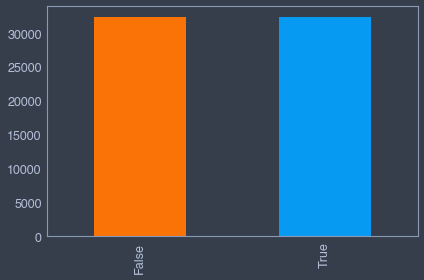

In [22]:
# create target label
df_cleaned['target'] = pos_class_mask

# add positive and negative classes together
df_concat = pd.concat([df_cleaned[neg_class].sample(updated_class_size), df_cleaned[pos_class_mask]], axis=0)
print(df_concat.groupby('target').describe()['score'])

# plot target distribution to validate
df_concat['target'].value_counts().plot(kind='bar', color=['xkcd:orange', 'xkcd:azure'])
plt.grid(False)
save_fig('class distribution after cleaning')

### Split into train / test data

In [23]:
# get training size from parameters
training_size = int(len(df_concat)*TRAIN_SIZE)

# shuffle 
df_concat_shuffled = df_concat.sample(len(df_concat))

# fill na values with a blank
df_concat_shuffled['selftext'] = df_concat_shuffled['selftext'].fillna(value='')

# generate train and test sets
train = df_concat_shuffled[:training_size]
test = df_concat_shuffled[training_size:]
print(train.shape, test.shape)

(61510, 15) (3238, 15)


In [24]:
# save to pickle
pd.to_pickle(train, "./data/train.pkl")
pd.to_pickle(test, "./data/test.pkl")